## Data Mining Assignment 2





**Members**

Pelema Abraham 218037538

David John 217063098

## What we are mining 

-which barbershop type makes more money(traditional or online based) and why

We were approached by a client that wants to start a barbershop, he wants us to recommend to him which type of barbershop he should start, online or traditional.
An online barbershop is mobile and clients call him to go to them while a traditional barbershop is located in building where clients come to get their hair done. 
We've collected a sample of 50 barbers that operate in town, windhoek. Barbers filled out forms that were sent to them.

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from apyori import apriori
import numpy as np
import sklearn
from sklearn import cluster
from sklearn.cluster import KMeans
import networkx as nx
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

In [95]:
df = pd.read_csv("./barbershop.csv")
df.head()


,cellphone,hairstyle,cost,monthly_rent,transport_cost,clients_per_month,monthly_income,form_of_transport,working_hours,clients_cut per trip,shop_type,promotion_platform_1,promotion_platform_2
0,819107859,Trim,80,2500.0,800,380,13000,taxi,6am-5pm,NaN,building,none,none
1,818659596,Temple Fade,70,2800.0,760,540,14000,private_car,6am-5pm,NaN,building,instagram,none
2,817122486,Low Fade,70,3500.0,730,520,14000,taxi,6am-12pm,NaN,building,instagram,whatsapp
3,813777117,Mohawk,70,3800.0,410,360,14000,taxi,6am-5pm,NaN,building,none,none
4,817028800,Low Fade,60,2200.0,580,550,15000,taxi,6am-12pm,NaN,building,none,none


**Data preprossing**

-cleaning

check if there are any null values, helps understand the structure of our current data

In [96]:

df.isnull().any()

cellphone               False
hairstyle               False
cost                    False
monthly_rent             True
transport_cost          False
clients_per_month       False
monthly_income          False
form_of_transport       False
working_hours           False
clients_cut per trip     True
shop_type               False
promotion_platform_1    False
promotion_platform_2    False
dtype: bool

Replace missing values depending on the data type,


In [97]:
median = df['transport_cost'].median()
df.fillna({'monthly_rent':0, 'clients_per_trip': 0, 'transport_cost':median}, inplace=True)
# res = df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))

In [98]:
#drop redundant working_hours column
df.drop(columns=['working_hours', 'cellphone'], inplace=True)
#check data types of our column,
#this guides as what type operations we can perform on them
#and the graphs that will be suitable to represent them
df.dtypes

hairstyle                object
cost                      int64
monthly_rent            float64
transport_cost            int64
clients_per_month         int64
monthly_income            int64
form_of_transport        object
clients_cut per trip    float64
shop_type                object
promotion_platform_1     object
promotion_platform_2     object
dtype: object

Calculate the avarage null values in the dataset
This tells us that:
overrall most of the columns are filled
50% of the records in the monthly rent column are null
while only 49% in clients cut per trip are null

In [99]:
df.isnull().sum() / len(df)

hairstyle               0.00
cost                    0.00
monthly_rent            0.00
transport_cost          0.00
clients_per_month       0.00
monthly_income          0.00
form_of_transport       0.00
clients_cut per trip    0.48
shop_type               0.00
promotion_platform_1    0.00
promotion_platform_2    0.00
dtype: float64

Format all string types to lower case

In [100]:
df['hairstyle'].str.lower()

0             trim
1      temple fade
2         low fade
3           mohawk
4         low fade
5      temple fade
6     waves + fade
7           mohawk
8           mohawk
9         low fade
10     temple fade
11     temple fade
12        low fade
13     temple fade
14     temple fade
15     temple fade
16        low fade
17        low fade
18          mohawk
19        low fade
20        low fade
21    waves + fade
22          mohawk
23        low fade
24     temple fade
25        low fade
26     temple fade
27            trim
28          mohawk
29        low fade
30          mohawk
31          mohawk
32    waves + fade
33            trim
34        low fade
35        low fade
36        low fade
37        low fade
38          mohawk
39          mohawk
40          mohawk
41            fade
42        low fade
43     temple fade
44     temple fade
45          mohawk
46        low fade
47        low fade
48     temple fade
49    waves + fade
Name: hairstyle, dtype: object

Fix column names that might cause issues down the road

In [101]:
df.rename(columns={'clients_cut per trip':'clients_per_trip'}, inplace=True)

In [102]:
profit = df['monthly_income']-df['monthly_rent']-df['transport_cost']
df['profit'] = profit

#split data set into online and building
online_df = df[df['shop_type'] == 'online']
traditional_df = df[df['shop_type'] == 'building']

# 1.Data Modeling
Data modeling refers to a group of processes in which multiple sets of data are combined and analyzed 
to uncover relationships or patterns. The goal of data modeling is to use past data to inform future efforts.

In [103]:
df.describe()

,cost,monthly_rent,transport_cost,clients_per_month,monthly_income,clients_per_trip,profit
count,50.000000,50.00000,50.000000,50.000000,50.00000,26.000000,50.000000
mean,70.600000,1484.00000,590.600000,460.800000,21460.00000,2.423077,19385.400000
std,13.910795,1548.45018,120.516067,69.188887,5639.54695,1.701131,6153.853019
min,50.000000,0.00000,400.000000,340.000000,12000.00000,1.000000,9700.000000
25%,60.000000,0.00000,485.000000,382.500000,16250.00000,1.000000,14160.000000
50%,70.000000,1000.00000,615.000000,470.000000,22000.00000,2.000000,19055.000000
75%,80.000000,3100.00000,697.500000,520.000000,26000.00000,3.000000,24400.000000
max,90.000000,3800.00000,800.000000,550.000000,34000.00000,7.000000,33300.000000


From the describe funtion gives us overrall descriptive analysis, from this we see that:
We took a sample of 50 barbers of which the avarage price of a hair cut is N\\$ 70, with one standard deviation from the mean price bieng N\\$ 13.
The minimum price for a hair cut is N\\$50 while the highest amounts to N\\$90.
50% of the hair cut price fall below N\\$70, and the monthly income bieng N\\$22 000.

On average a barber makes N\\$19 300 profit per month with a single standard deviation of N\\$ 6 000


**Data Distribution**

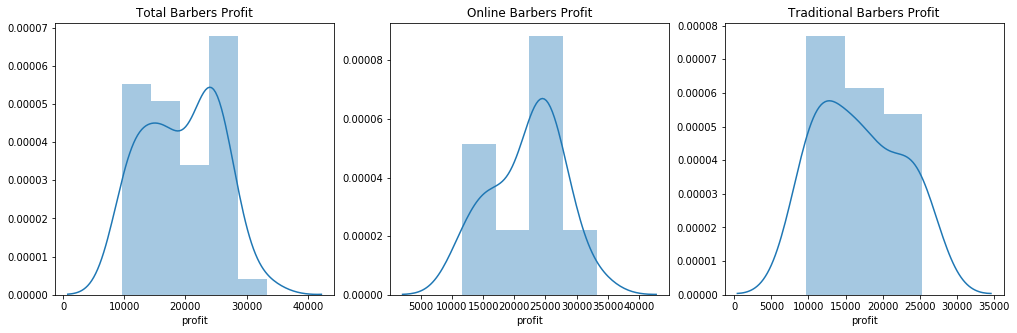

In [154]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(17, 5)

axes[0].set_title("Total Barbers Profit")
axes[1].set_title("Online Barbers Profit")
axes[2].set_title("Traditional Barbers Profit")

filter_data = df.dropna(subset=['profit'])
sns.distplot(filter_data['profit'], ax=axes[0])

filter_data = online_df.dropna(subset=['profit'])
sns.distplot(filter_data['profit'], ax=axes[1])

filter_data = traditional_df.dropna(subset=['profit'])
sns.distplot(filter_data['profit'], ax=axes[2])

Distribution analysis plot shows us the general pattern that our data follow, first thing to notice from the above graph is that our data is not symmetrical and does not follow a normal distribution.
This graph shows that most online barbers make around N\\$ 25 000 while Traditional are at around N\\$ 14 000 profit

**Statistical Regression**

In [105]:
#linear regression

In [106]:
m = ols('profit ~ monthly_income - transport_cost - transport_cost', df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     725.1
Date:                Wed, 01 Jul 2020   Prob (F-statistic):           1.27e-30
Time:                        18:19:32   Log-Likelihood:                -437.20
No. Observations:                  50   AIC:                             878.4
Df Residuals:                      48   BIC:                             882.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3293.0811    870.225     -3.

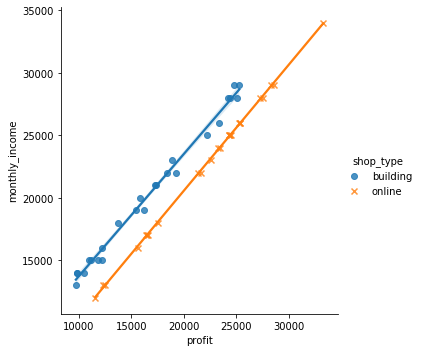

In [107]:
sns.lmplot(x="profit", y="monthly_income", hue="shop_type", data=df, markers=["o", "x"])
plt.show()

Regression analysis aims to plot out data points in our data set and draw division between those points to differentiate them. Regression draws the best fit line shows how far other data points are from that line.


# 2.Identifying Patterns 

In [123]:
df2 = df[['hairstyle','shop_type']]

records = []
for i in range(0, df2.shape[0]):
    records.append([str(df2.values[i,j]) for j in range(0, len(df2.columns))])

association_rules = apriori(records,use_colnames = True, min_length=2)
association_results = list(association_rules)


In [109]:
for item in association_results:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    if(len(items) < 2):
        continue
        
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")


Rule: building -> Low Fade
Support: 0.18
Confidence: 0.18
Lift: 1.0
Rule: online -> Low Fade
Support: 0.18
Confidence: 0.18
Lift: 1.0
Rule: building -> Mohawk
Support: 0.1
Confidence: 0.1
Lift: 1.0
Rule: online -> Mohawk
Support: 0.14
Confidence: 0.14
Lift: 1.0
Rule: building -> Temple Fade
Support: 0.16
Confidence: 0.16
Lift: 1.0


We use apryori algorithm to find the association between haircut types and shop types, this will help us understand which haircut the is favoured by online and traditional community.
To increase his profit the barber will to master the type of hair cut that his customers like.

First of all lets define some terms:
Support - overrall popularity of a hairstyle,  number of transactions containing a particular hairstyle over total transactions

Confidence - likely of hairstyle A if shop type B is chosen, vice versa.

Lift - lift(A->B) is the increase in ratio of haircut B when shop type A is used, vice versa.


From our analysis we found that all our associations have a lift of 1, so there's no association between the shop type and hairstyle favoured. There difference in support and confidence is negligible.


# 3.Data Visualization

**Scatter Plot**

Scatter plots are used to plot data points on horizontal and vertical axis in the attempt to show how much one variable is affected by another. 

Text(0, 0.5, 'Clients per Month')

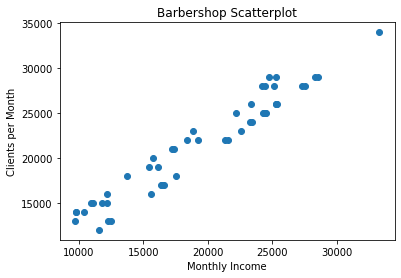

In [110]:
plt.scatter(df.profit, df.monthly_income)
plt.title('Barbershop Scatterplot')
plt.xlabel('Monthly Income')
plt.ylabel('Clients per Month')

**Data Cluster**

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares.

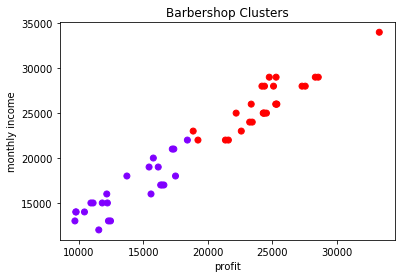

In [125]:
df2 = df.dropna(axis='columns')
kmeans = KMeans(n_clusters=2).fit(df2._get_numeric_data())
centroids = kmeans.cluster_centers_

plt.scatter(df['profit'], df['monthly_income'], c=kmeans.labels_, cmap='rainbow')
plt.title('Barbershop Clusters')
plt.xlabel('profit')
plt.ylabel('monthly income')
plt.show()

**Histogram**

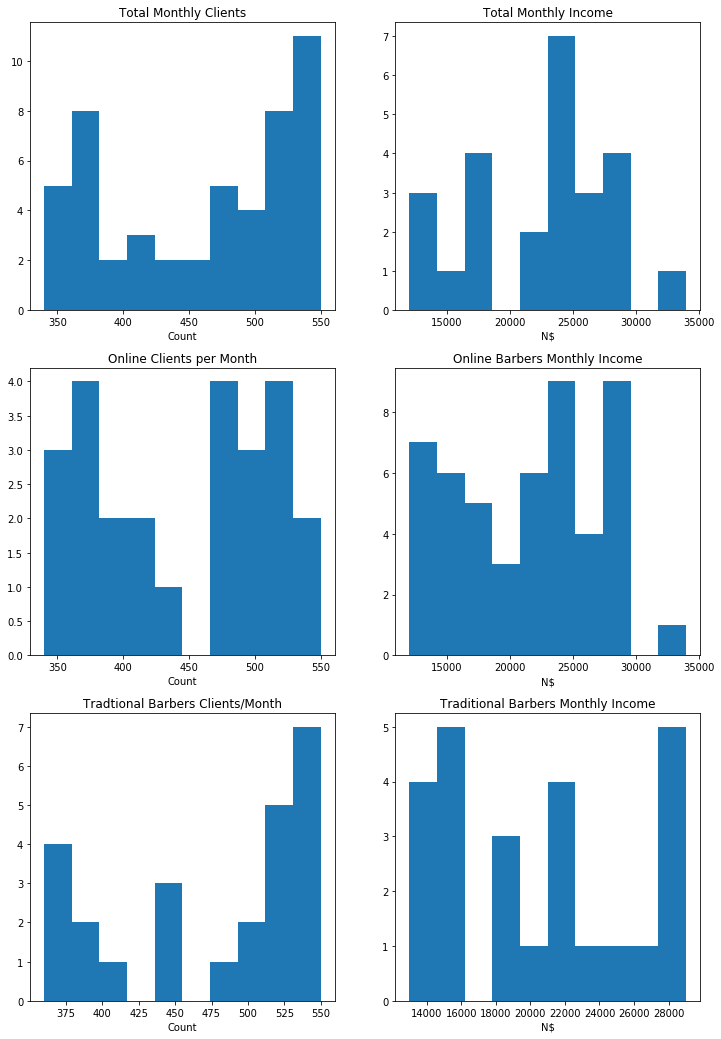

In [130]:
fig = plt.figure(figsize=(12, 18))
total_clients = fig.add_subplot(321)
total_income = fig.add_subplot(322)

online_clients = fig.add_subplot(323)
online_income = fig.add_subplot(324)

traditional_clients = fig.add_subplot(325)
traditional_income = fig.add_subplot(326)

total_clients.hist(df.clients_per_month)
total_clients.set_xlabel('Count')
total_clients.set_title("Total Monthly Clients")

total_income.hist(online_df.monthly_income)
total_income.set_xlabel('N$')
total_income.set_title("Total Monthly Income")

online_clients.hist(online_df.clients_per_month)
online_clients.set_xlabel('Count')
online_clients.set_title("Online Clients per Month")

online_income.hist(df.monthly_income)
online_income.set_xlabel('N$')
online_income.set_title("Online Barbers Monthly Income")

traditional_clients.hist(traditional_df.clients_per_month)
traditional_clients.set_xlabel('Count')
traditional_clients.set_title("Tradtional Barbers Clients/Month")

traditional_income.hist(traditional_df.monthly_income)
traditional_income.set_xlabel('N$')
traditional_income.set_title("Traditional Barbers Monthly Income")

plt.show()

The histogram show the frequeceny of monthly customers and the the total income for that month.

**Box Plot**

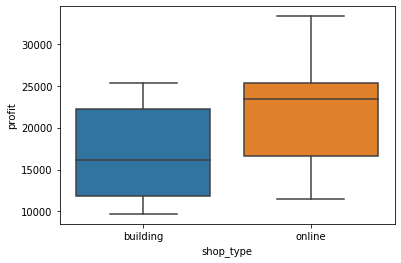

In [137]:
ax = sns.boxplot(x='shop_type', y='profit', data=df, orient="v")

**Pie Chart**

           prtype
instagram      12
whatsapp        6
facebook        7


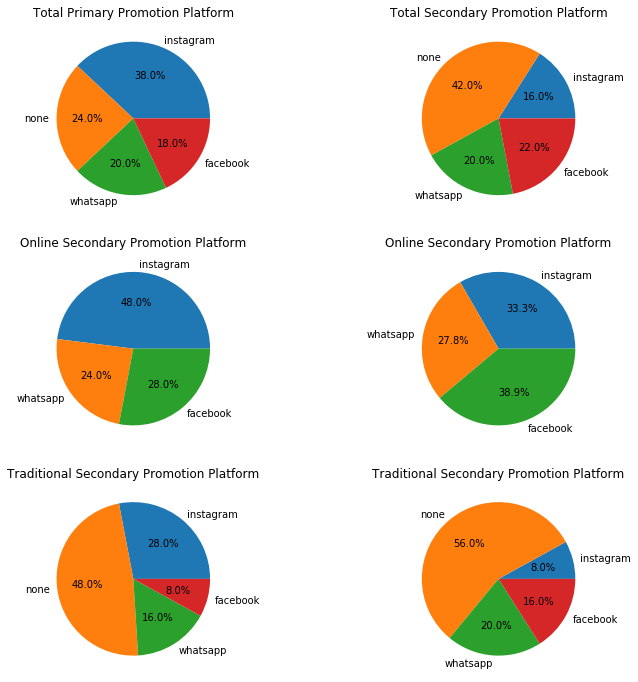

In [122]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

one = fig.add_subplot(321)
two = fig.add_subplot(322)
three = fig.add_subplot(323)
four = fig.add_subplot(324)
five = fig.add_subplot(325)
six = fig.add_subplot(326)

one.set_title("Total Primary Promotion Platform")
two.set_title("Total Secondary Promotion Platform")
three.set_title("Online Secondary Promotion Platform")
four.set_title("Online Secondary Promotion Platform")
five.set_title("Traditional Secondary Promotion Platform")
six.set_title("Traditional Secondary Promotion Platform")

type_counts_1 = df['promotion_platform_1'].value_counts()
type_counts_2 = df['promotion_platform_2'].value_counts()

type_counts_online_1 = online_df['promotion_platform_1'].value_counts()
type_counts_online_2 = online_df['promotion_platform_2'].value_counts()

type_counts_traditional_1 = traditional_df['promotion_platform_1'].value_counts()
type_counts_traditional_2 = traditional_df['promotion_platform_2'].value_counts()


df1 = pd.DataFrame({'prtype': type_counts_1}, 
                  index = ['instagram', 'none', 'whatsapp', 'facebook'])
df2 = pd.DataFrame({'prtype': type_counts_2}, 
                  index = ['instagram', 'none', 'whatsapp', 'facebook'])
df3 = pd.DataFrame({'prtype': type_counts_online_1}, 
                  index = ['instagram', 'whatsapp', 'facebook'])
df4 = pd.DataFrame({'prtype': type_counts_online_2}, 
                  index = ['instagram', 'whatsapp', 'facebook'])
df5 = pd.DataFrame({'prtype': type_counts_traditional_1}, 
                  index = ['instagram', 'none', 'whatsapp', 'facebook'])
df6 = pd.DataFrame({'prtype': type_counts_traditional_2}, 
                  index = ['instagram', 'none', 'whatsapp', 'facebook'])

one.pie(df1['prtype'],labels=['instagram', 'none', 'whatsapp', 'facebook'], autopct='%1.1f%%')
two.pie(df2['prtype'],labels=['instagram', 'none', 'whatsapp', 'facebook'], autopct='%1.1f%%')
three.pie(df3['prtype'],labels=['instagram', 'whatsapp', 'facebook'], autopct='%1.1f%%')
four.pie(df4['prtype'],labels=['instagram', 'whatsapp', 'facebook'], autopct='%1.1f%%')
five.pie(df5['prtype'],labels=['instagram', 'none', 'whatsapp', 'facebook'], autopct='%1.1f%%')
six.pie(df6['prtype'],labels=['instagram', 'none', 'whatsapp', 'facebook'], autopct='%1.1f%%')

plt.show(block=False)

A pie graphs proportions of classes in a population, here observe the proportion of barbers that use social media to promote their business. We found that majority (38%) of barbers use only instagram for promotion. The least used primary platform is facebook scoring at 18%.
48% of online barber choose instagram as their primary platform while only 28% of traditional barber use instagram. Majority(48%) of traditional barbers do not use any social media platform to promote their barbershops.

**Bar Graph**

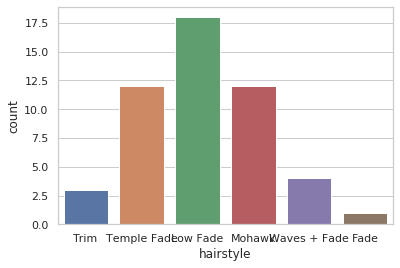

In [40]:
ax = sns.countplot(x='hairstyle', data=df)

We use a bar graph to find the most liked hair style, in our findings the low fade seems to be most like, second best is the temple fade while the normal fade is the least cut.

# 4.Prototype

(Transitioning modelling - show using a graph and little explanation)

## Conlusion

We've found that on average althoug both traditional and online barbers bring in around the same monthly income, traditional barbers profits are often lower due to higher fixed costs such as monthly rent.